**Chapter 5 – Support Vector Machines**

_This notebook contains all the sample code and solutions to the exercises in chapter 5._

A Support Vector Machine (SVM) is a very powerful and versatile Machine Learning model, capable of performing linear or nonlinear classification, regression, and even outlier detection. It is best suited for classification of complex but small- or medium-sized datasets. <br>

It is a non-probabalistic supervised learning methods which can be used for classification and regression. An SVM model is a representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible. SVM can be used for unsupervised learning via clustering, but we don't show these applications, yet.

SVM fits a hyperplane that maximizes the distance between the hyperplane and the nearest observations. Sometimes a linear hyperplane is difficult to fit and we can use a nonlinear one using kernel function: $\sum_{i}\alpha_i k(x_i , x) = constant$.

# Linear Classification

SVM can be linear when classes can clearly be separated easily with a straight line (they are linearly separable *picture*). When the separation is complete classification is easy. The difficulty arises when there is an extensive overlap between classes(*picture*). Linear regression tries to fit all point, the SVM stays as far away from the closest training instances as possible. You can think of an SVM classifier as fitting the widest possible street (represented by the parallel dashed lines) between the classes. This is called large margin classification. SVM is very sensitive to scaling, so it is a must when applying this algorithm. 

We estimate a hyperplane $w \cdot x - b = 0$ trying to maximize a margin -- distance between nearest data points and the hyper plance. 




In [21]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

If the training data is linearly separable, we can select two parallel hyperplanes that separate the two classes of data, so that the distance between them is as large as possible. The region bounded by these two hyperplanes is called the "margin", and the maximum-margin hyperplane is the hyperplane that lies halfway between them. With a normalized or standardized dataset, these hyperplanes can be described by the following equations: 
$\vec{w}\cdot\vec{x} - b=1$ (anything on or above this boundary is of one class, with label 1) and $\vec{w}\cdot\vec{x} - b=-1$.\,</math> (anything on or below this boundary is of the other class, with label -1).
Geometrically, the distance between these two hyperplanes is $\tfrac{2}{\|\vec{w}\|}$, so to maximize the distance between the planes we want to minimize $\|\vec{w}\|$.  <br>

We also have to prevent data points from falling into the margin, we add the following constraint: for each $i$ either:
$\vec{w}\cdot\vec{x}_i - b \ge 1$ if $y_i = 1$ or $\vec{w}\cdot\vec{x}_i - b \le -1$ if $y_i = -1$. </math>
These constraints state that each data point must lie on the correct side of the margin.
This can be rewritten as: $y_i(\vec{w}\cdot\vec{x}_i - b) \ge 1, \quad \text{ for all } 1 \le i \le n$<br>
We can put this together to get the optimization problem:<br>
Minimize $\|\vec{w}\|$ subject to $y_i(\vec{w}\cdot\vec{x}_i - b) \ge 1,$ for $i = 1,\,\ldots,\,n$.

# Soft Margin

To extend SVM to cases in which the data are not linearly separable, we introduce the hinge loss function: <br>
$$\max\left(0, 1-y_i(\vec{w}\cdot\vec{x}_i - b)\right)$$

Note that $y_i$ is the ith target (i.e., in this case, 1 or -1), and $(\vec{w}\cdot\vec{x}_i - b)$ is the current output.

This function is zero if $\vec{x}_i$ lies on the correct side of the margin. For data on the wrong side of the margin, the function's value is proportional to the distance from the margin. We then wish to minimize 
$$\left[\frac 1 n \sum_{i=1}^n \max\left(0, 1 - y_i(\vec{w}\cdot \vec{x}_i - b)\right) \right] + \lambda\lVert \vec{w} \rVert^2,$$

where the parameter $\lambda$ determines the tradeoff between increasing the margin-size and ensuring that the $\vec{x}_i$ lie on the correct side of the margin. Thus, for sufficiently small values of $\lambda$, the second term in the loss function will become negligible, hence, it will behave similar to the hard-margin SVM, if the input data are linearly classifiable, but will still learn if a classification rule is viable or not.

# Large margin classification

The next few code cells generate the first figures in chapter 5. The first actual code sample comes after:

In [22]:
# import SVM package
from sklearn.svm import SVC
# import datasets
from sklearn import datasets
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]
# create a binary classifier for two flowers: Versicolor or Setosa
setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM Classifier model. Linear Kernel models straight line. 
# C is the soft-margin parameter, more about it later. Here we estimat a hard-margin model, where we want to 
# correctly classify all data points.
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

SVC(C=inf, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Below we will plot margins of the predicted classes using SVM. 

Saving figure large_margin_classification_plot


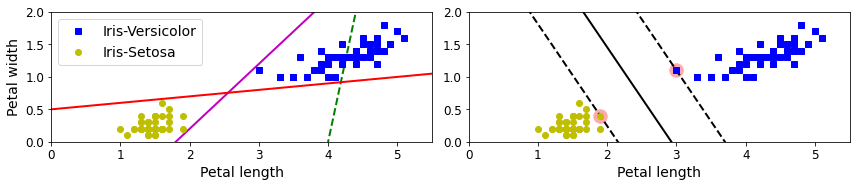

In [23]:
# Bad models
x0 = np.linspace(0, 5.5, 200)
# Generate three prediction lines
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5
# create a function that plots decision boundary
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    # Get plot and intercept
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # we predict positive or negative. The formula for the line is:
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    # line as a function of x0
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]
    margin = 1/w[1]# add margin
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    
    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

plt.figure(figsize=(12,2.7))

plt.subplot(121)
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.subplot(122)
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

save_fig("large_margin_classification_plot")
plt.show()

# Sensitivity to feature scales

Saving figure sensitivity_to_feature_scales_plot


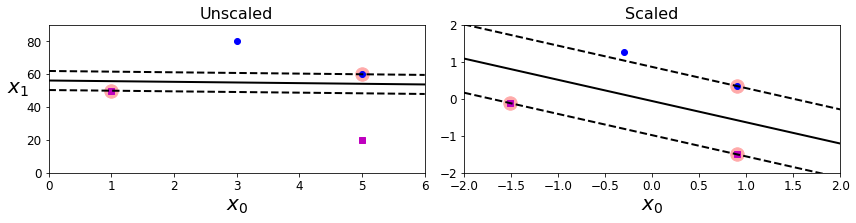

In [24]:
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100)
svm_clf.fit(Xs, ys)

plt.figure(figsize=(12,3.2))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$  ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x_0$", fontsize=20)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

save_fig("sensitivity_to_feature_scales_plot")


# Sensitivity to outliers

Saving figure sensitivity_to_outliers_plot


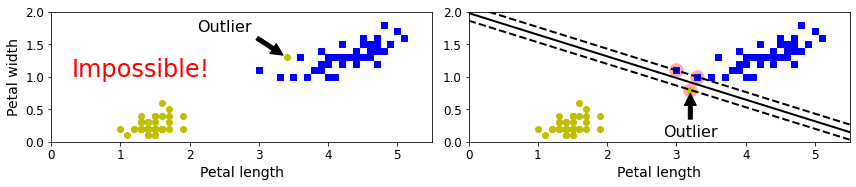

In [25]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

plt.figure(figsize=(12,2.7))

plt.subplot(121)
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.subplot(122)
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

save_fig("sensitivity_to_outliers_plot")
plt.show()

# Large margin *vs* margin violations

# Soft Margin Classification

If we strictly impose that all instances be off the street and on the right side, this is called hard margin classification. It only works if the data is linearly separable and is very sensitive to outliers. Just one additional outlier makes it hard or impossible to find a hard margin (*picture*). Soft Margin is a more flexible model that finds a good balance between keeping the street as large as possible and limiting the margin violations (i.e., instances that end up in the middle of the street or even on the wrong side). 

In Scikit-Learn’s SVM classes, you can control this balance using the C hyperparameter: a smaller C value leads to a wider street but more margin violations. High C value the classifier makes fewer margin violations but ends up with a smaller margin. Low C value the margin is much larger, but many instances end up on the street. Generally, it is a good idea to have wider margin for out-of-sample prediction. 

In Scikit-Learn’s SVM classes, you can control this balance using the $C$ hyperparameter: a smaller $C$ value
leads to a wider street but more margin violations. On the left, a high $C$ value classifier makes fewer margin violations but ends up with a smaller margin. On the right, in a low $C$ value classifier the margin is much larger, but many instances end up on the street. The high-C classifier is likely to generalize better on the validation dataset. 

This is the first code example in chapter 5:

In [26]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
# Import LinearSVM
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris-Virginica

svm_clf = Pipeline([
# Scale data
        ("scaler", StandardScaler()),
# Soft margin data with C =1 
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [27]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

Now let's generate the graph comparing different regularization settings:

In [28]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)

scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=100, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [29]:
# Convert to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# Find support vectors (LinearSVC does not do this automatically)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

Saving figure regularization_plot


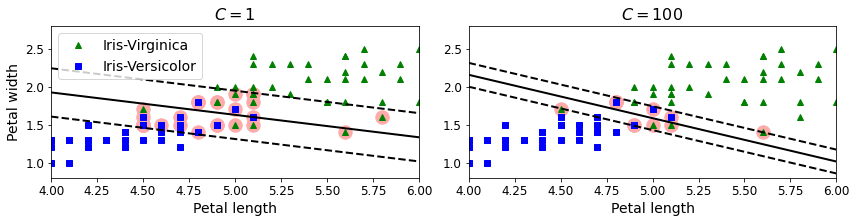

In [31]:
plt.figure(figsize=(12,3.2))
plt.subplot(121)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris-Virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris-Versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

plt.subplot(122)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 6, 0.8, 2.8])

save_fig("regularization_plot")

# Non-linear classification

Although linear SVM classifiers are efficient and work surprisingly well in many cases, many datasets
are not even close to being linearly separable. <br>
One approach to handling nonlinear datasets is to add more features, such as polynomial features; in some cases this can result in a linearly separable dataset. <br> Consider a simple dataset with just one feature $x_1$. This dataset is not linearly separable. But if you add a second feature $x_2 = (x_{1})^2$, the resulting 2D dataset is perfectly linearly separable.

Saving figure higher_dimensions_plot


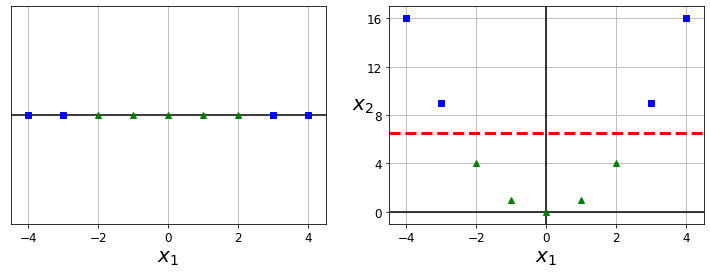

In [32]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
X2D = np.c_[X1D, X1D**2]
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$", fontsize=20, rotation=0)
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

save_fig("higher_dimensions_plot", tight_layout=False)
plt.show()

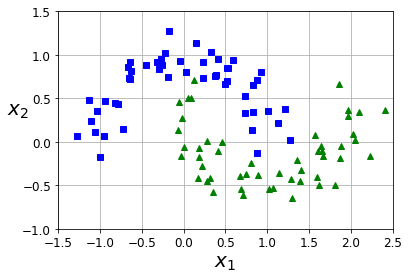

In [33]:
# Load a made-up dataset of interweaving half-circles.
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

In [34]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
# Create polynomial degress 3
        ("poly_features", PolynomialFeatures(degree=3)),
# Scale data
        ("scaler", StandardScaler()),
# Set soft margin and C = 10
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))
    ])

polynomial_svm_clf.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 LinearSVC(C=10, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=42, tol=0.0001,
                           verbose=0))],
         verbose=False)

Saving figure moons_polynomial_svc_plot


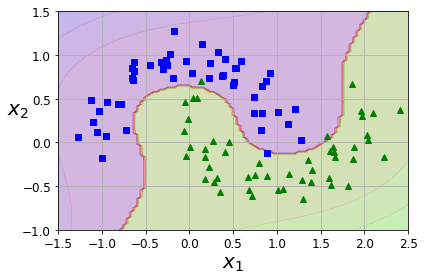

In [35]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    # plot grid
    x0, x1 = np.meshgrid(x0s, x1s)
    # flattens array
    X = np.c_[x0.ravel(), x1.ravel()]
    #predict y_hat
    y_pred = clf.predict(X).reshape(x0.shape)
    # plot decision function.
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

# Kernel trick
Adding polynomial features is simple to implement and can work great with all sorts of Machine Learning
algorithms (not just SVMs), but at a low polynomial degree it cannot deal with very complex datasets,
and with a high polynomial degree it creates a huge number of features, making the model too slow. <br>

Fortunately, when using SVMs you can apply an almost miraculous mathematical technique called the
kernel trick. It makes it possible to get the same result as if you added many
polynomial features, even with very high-degree polynomials, without actually having to add them. So
there is no combinatorial explosion of the number of features since you don’t actually add any features.
This trick is implemented by the SVC class. 

This code trains an SVM classifier using a 3rd-degree polynomial kernel. If your model is overfitting, you might want to reduce the polynomial degree. Conversely, if it is
underfitting, you can try increasing it. The hyperparameter coef0 controls how much the model is influenced by high-degree polynomials versus low-degree polynomials.

In [36]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
    #Polynomial kernel of degree 3
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, break_ties=False, cache_size=200, class_weight=None,
                     coef0=1, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [37]:
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=100, C=5))
    ])
poly100_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, break_ties=False, cache_size=200, class_weight=None,
                     coef0=100, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

Saving figure moons_kernelized_polynomial_svc_plot


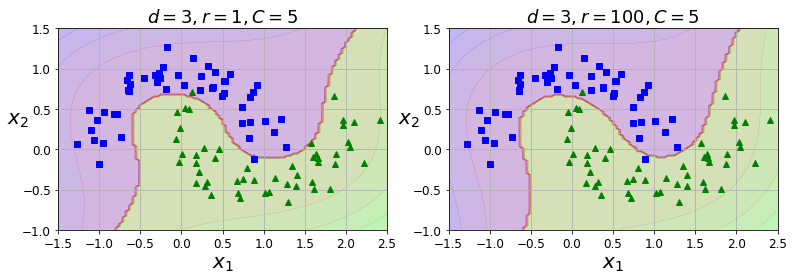

In [38]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

plt.subplot(122)
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.title(r"$d=3, r=100, C=5$", fontsize=18)

save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

# Adding Similarity Features
Another technique to tackle nonlinear problems is to add features computed using a similarity function that measures how much each instance resembles a particular landmark. For example, let’s take the one-dimensional
dataset discussed earlier and add two landmarks to it at $x_1 = –2$ and $x_1 = 1$. Next, let’s define the similarity function to be the Gaussian Radial Basis Function (RBF) with $\gamma = 0.3$ <br>
Gaussian RBF <br>
$$\phi \gamma(x,l) = exp(-\gamma || x - l ||^2)$$
It is a bell-shaped function varying from 0 (very far away from the landmark) to 1 (at the landmark). Let’s look at the instance $x_1 = –1$: it is located at a distance of 1 from the first landmark, and 2 from the second landmark. Therefore its new features are $x_2 = exp (–0.3 \times 1^2) \approx  0.74$ and $x_3 = exp(–0.3 \times 2^2) \approx 0.30$. The plot on the right of shows the transformed dataset (dropping the original features). As you can see, it is now linearly separable.

Saving figure kernel_method_plot


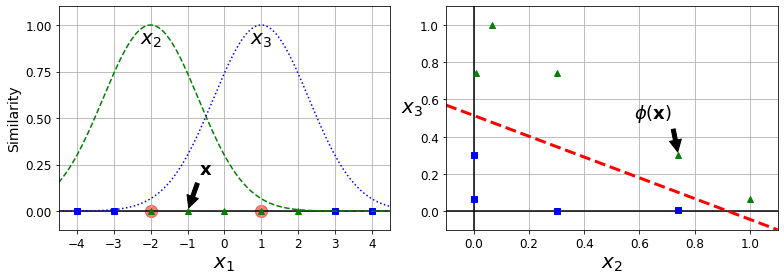

In [39]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

save_fig("kernel_method_plot")
plt.show()

How do we select the landmarks? The simplest approach is to create a landmark at the location of each and every instance in the dataset. This creates many dimensions and thus increases the
chances that the transformed training set will be linearly separable. The downside is that a training set
with m instances and n features gets transformed into a training set with m instances and m features (assuming you drop the original features). If your training set is very large, you end up with an equally large number of features.

In [40]:
x1_example = X1D[3, 0]
for landmark in (-2, 1):
    k = gaussian_rbf(np.array([[x1_example]]), np.array([[landmark]]), gamma)
    print("Phi({}, {}) = {}".format(x1_example, landmark, k))

Phi(-1.0, -2) = [0.74081822]
Phi(-1.0, 1) = [0.30119421]


# Gaussian RBF Kernel
We don't even have to add features with the kernel function and obtain the same result. <br>
This model is represented on the bottom left of of the picture below. The other plots show models trained with
different values of hyperparameters gamma ($\gamma$) and $C$. Increasing gamma makes the bell-shape curve
narrower, and as a result each instance’s range of influence is smaller: the decision boundary ends up being more irregular, wiggling around individual instances. <br>

Conversely, a small gamma value makes the bell-shaped curve wider, so instances have a larger range of influence, and
the decision boundary ends up smoother. So $\gamma$ acts like a regularization hyperparameter: if your model is
overfitting, you should reduce it, and if it is underfitting, you should increase it (similar to the C hyperparameter).

In [41]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
rbf_kernel_svm_clf.fit(X, y)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=0.001, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=5,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

Saving figure moons_rbf_svc_plot


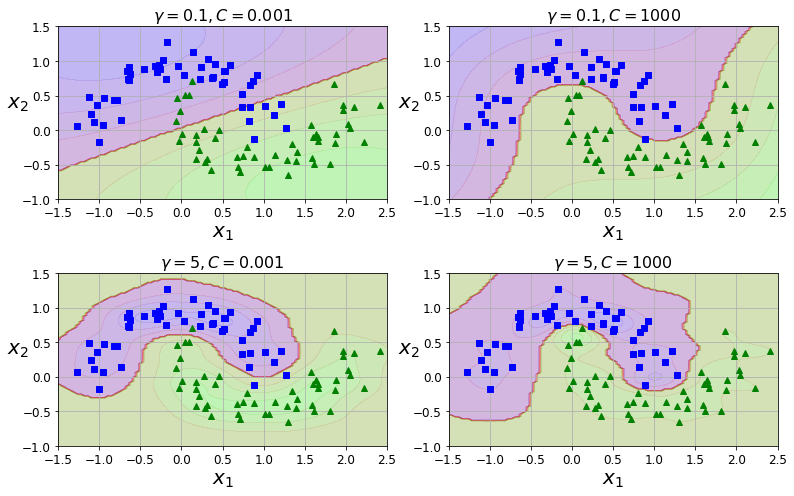

In [42]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

plt.figure(figsize=(11, 7))

for i, svm_clf in enumerate(svm_clfs):
    plt.subplot(221 + i)
    plot_predictions(svm_clf, [-1.5, 2.5, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)

save_fig("moons_rbf_svc_plot")
plt.show()

# Computational Complexity

The LinearSVC and SGDClassifier does not support the kernel trick, but it scales almost linearly with the number of training
instances and the number of features: its training time complexity is roughly $O(m \times n)$.
The algorithm takes longer if you require a very high precision. This is controlled by the tolerance
hyperparameter $\eta$ (called tol in Scikit-Learn).  In most classification tasks, the default tolerance is fine.
<br>
The SVC class is based on the libsvm library, which implements an algorithm that supports the kernel
trick. The training time complexity is usually between $O(m^2 \times n)$ and $O(m^3 \times n)$. Unfortunately, this
means that it gets dreadfully slow when the number of training instances gets large (e.g., hundreds of
thousands of instances). This algorithm is perfect for complex but small or medium training sets. <br>
However, it scales well with the number of features, especially with sparse features (i.e., when each
instance has few nonzero features). 

# Regression


The SVM algorithm also supports linear and nonlinear regression. The trick is to reverse the
objective: instead of trying to fit the largest possible street between two classes while limiting margin
violations, SVM Regression tries to fit as many instances as possible on the street while limiting margin
violations (i.e., instances off the street). The width of the street is controlled by a hyperparameter $\epsilon$.
Next we show two linear SVM Regression models trained on some random linear data, one with a large margin ($\epsilon$ = 1.5) and the other with a small margin ($\epsilon$ = 0.5).

In [43]:
np.random.seed(42)
# 50 observations
m = 50
# Random regression data
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()

In [44]:
from sklearn.svm import LinearSVR
# Get SVM regression
svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

LinearSVR(C=1.0, dual=True, epsilon=1.5, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=42, tol=0.0001, verbose=0)

In [45]:
# Specify SVM regression models
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)
# Find support vecors
def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

Saving figure svm_regression_plot


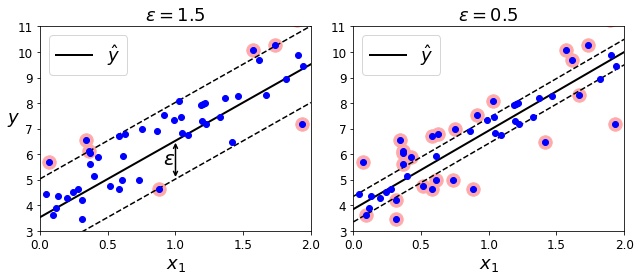

In [46]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.subplot(122)
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
save_fig("svm_regression_plot")
plt.show()

Adding more training instances within the margin does not affect the model’s predictions. Let's try the model on the second degree polynomial. High $C$ is high regularization -- larger coefficients.

In [47]:
svm_reg1.coef_

array([2.99278375])

In [48]:
svm_reg2.coef_

array([3.07335015])

In [49]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

In [50]:
from sklearn.svm import SVR
# polynomial kernel
svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X, y)

SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [51]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1)
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

Saving figure svm_with_polynomial_kernel_plot


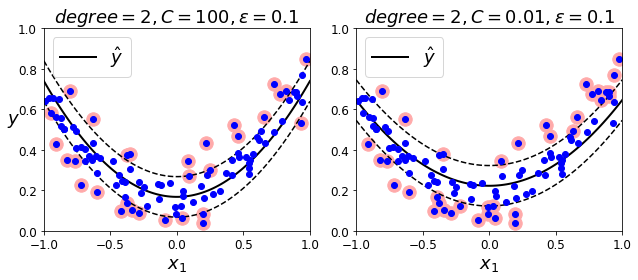

In [52]:
plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.subplot(122)
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
save_fig("svm_with_polynomial_kernel_plot")
plt.show()

# Under the hood

# SVM Model

In the regular model we estimate vector $\theta$, including the bias term $\theta_0$ and the input feature weights $\theta_1$ to $\theta_n$, and adding a bias input $x_0 = 1$ to all instances. SVM uses a different conventionthe bias term is $b$ and the feature weights vector is $w$. No bias feature will be added to the input feature vectors. <br>

The linear SVM classifier model predicts the class of a new instance $x$ by simply computing the decision
function $w^T \cdot x + b = w_1 x_1 + ... + w_n x_n + b$: if the result is positive, the predicted class $\hat{y}$ is the positive class (1), or else it is the negative class (0):
$\hat{y} = \begin{cases} 
          0 \qquad if \quad x^T \cdot x + b < 0, \\
          1 \qquad if \quad x^T \cdot x + b \geq 0 \\  \end{cases}$ <br>
The decision boundary is the set of points where the decision function is equal to 0: it is the intersection of two planes,
which is a straight line (represented by the thick solid line). The dashed lines represent the points where the decision function is equal to 1 or –1: they are parallel and at equal distance to the decision boundary, forming a margin around it. Training a linear SVM classifiermeans finding the value of w and b that make this margin as wide as possible while avoiding margin violations (hard margin) or limiting them (soft margin).              

In [ ]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.float64)  # Iris-Virginica

Saving figure iris_3D_plot


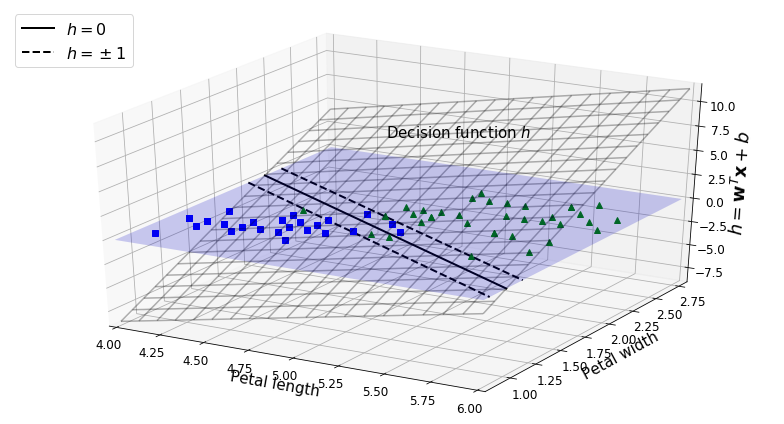

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3D_decision_function(ax, w, b, x1_lim=[4, 6], x2_lim=[0.8, 2.8]):
    x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])
    X_crop = X[x1_in_bounds]
    y_crop = y[x1_in_bounds]
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    df = (xs.dot(w) + b).reshape(x1.shape)
    m = 1 / np.linalg.norm(w)
    boundary_x2s = -x1s*(w[0]/w[1])-b/w[1]
    margin_x2s_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    ax.plot_surface(x1s, x2, np.zeros_like(x1),
                    color="b", alpha=0.2, cstride=100, rstride=100)
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
    ax.plot(X_crop[:, 0][y_crop==1], X_crop[:, 1][y_crop==1], 0, "g^")
    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
    ax.plot(X_crop[:, 0][y_crop==0], X_crop[:, 1][y_crop==0], 0, "bs")
    ax.axis(x1_lim + x2_lim)
    ax.text(4.5, 2.5, 3.8, "Decision function $h$", fontsize=15)
    ax.set_xlabel(r"Petal length", fontsize=15)
    ax.set_ylabel(r"Petal width", fontsize=15)
    ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=18)
    ax.legend(loc="upper left", fontsize=16)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111, projection='3d')
plot_3D_decision_function(ax1, w=svm_clf2.coef_[0], b=svm_clf2.intercept_[0])

save_fig("iris_3D_plot")
plt.show()

# Small weight vector results in a large margin

# Training Objective

Consider the slope of the decision function: it is equal to the norm of the weight vector, $∥ w ∥$. If we
divide this slope by 2, the points where the decision function is equal to $\pm 1$ are going to be twice as far
away from the decision boundary. In other words, dividing the slope by 2 will multiply the margin by 2.

Saving figure small_w_large_margin_plot


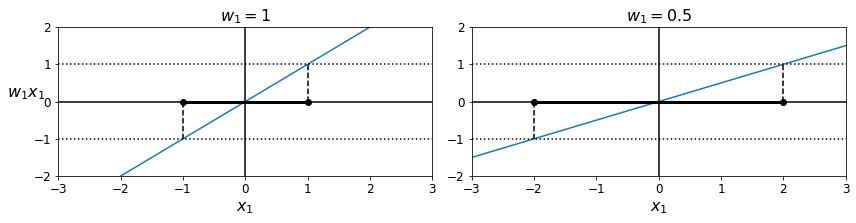

In [53]:
def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    m = 1 / w

    plt.plot(x1, y)
    plt.plot(x1_lim, [1, 1], "k:")
    plt.plot(x1_lim, [-1, -1], "k:")
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot([m, m], [0, 1], "k--")
    plt.plot([-m, -m], [0, -1], "k--")
    plt.plot([-m, m], [0, 0], "k-o", linewidth=3)
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel(r"$x_1$", fontsize=16)
    if ylabel:
        plt.ylabel(r"$w_1 x_1$  ", rotation=0, fontsize=16)
    plt.title(r"$w_1 = {}$".format(w), fontsize=16)

plt.figure(figsize=(12, 3.2))
plt.subplot(121)
plot_2D_decision_function(1, 0)
plt.subplot(122)
plot_2D_decision_function(0.5, 0, ylabel=False)
save_fig("small_w_large_margin_plot")
plt.show()

In [54]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64) # Iris-Virginica

svm_clf = SVC(kernel="linear", C=1)
svm_clf.fit(X, y)
svm_clf.predict([[5.3, 1.3]])

array([1.])

So we want to minimize $|| w ||$ to get a large margin and  we also want to avoid any margin
violation (hard margin).We need the decision function to be greater than 1 for all positive training
instances, and lower than –1 for negative training instances. If we define $t(i) = –1$ for negative instances (if
$y(i) = 0$) and $t(i) = 1$ for positive instances (if $y(i) = 1$), then we can express this constraint as $t(i)(w^T \cdot x^{(i)} + b) \ge 1$ for all instances.
We can therefore express the hard margin linear SVM classifier objective as the constrained
optimization problem: <br>
$$minimize_{w,b} \quad \frac{1}{2} w^T \cdot w$$ <br>
subject to $t^{(i)}(w^T \cdot x^{(i)} + b) \ge 1$ for $ i = 1,2 ... , m$

To get the soft margin objective, we need to introduce a slack variable $\zeta(i) \ge 0$ for each instance: $\zeta(i)$
measures how much the ith instance is allowed to violate the margin. We now have two conflicting objectives: making the slack variables as small as possible to reduce the margin violations, and making $w^T \cdot w$ as small as possible to increase the margin. This is where the C hyperparameter comes in: it
allows us to define the tradeoff between these two objectives. This gives us the constrained optimization
problem:
$$minimize_{w,b,\zeta} \quad \frac{1}{2} w^T \cdot w + C \sum^m_{i=1} \zeta^{(i)}$$ <br>
subject to $t^{(i)}(w^T \cdot x^{(i)} + b) \ge 1 - \zeta^{(i)}$ and $\zeta^{(i)} \ge 0$ for $ i = 1,2 ... , m$


# Hinge loss

Saving figure hinge_plot


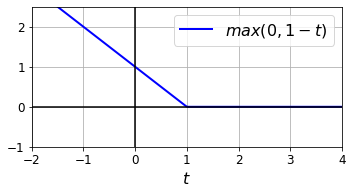

In [55]:
t = np.linspace(-2, 4, 200)
h = np.where(1 - t < 0, 0, 1 - t)  # max(0, 1-t)

plt.figure(figsize=(5,2.8))
plt.plot(t, h, "b-", linewidth=2, label="$max(0, 1 - t)$")
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.yticks(np.arange(-1, 2.5, 1))
plt.xlabel("$t$", fontsize=16)
plt.axis([-2, 4, -1, 2.5])
plt.legend(loc="upper right", fontsize=16)
save_fig("hinge_plot")
plt.show()

# Extra material

## Training time

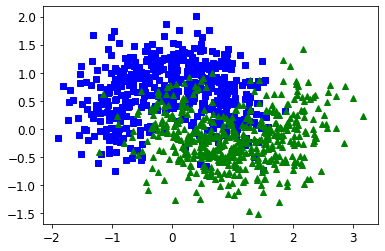

In [ ]:
# Let's train 1000 half-moons
X, y = make_moons(n_samples=1000, noise=0.4, random_state=42)
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")

[LibSVM]0 0.1 0.21724939346313477
[LibSVM]1 0.01 0.2804098129272461
[LibSVM]2 0.001 0.4514944553375244
[LibSVM]3 0.0001 0.3581876754760742
[LibSVM]4 1e-05 0.35882139205932617
[LibSVM]5 1.0000000000000002e-06 0.5391108989715576
[LibSVM]6 1.0000000000000002e-07 0.45277929306030273
[LibSVM]7 1.0000000000000002e-08 0.4764537811279297
[LibSVM]8 1.0000000000000003e-09 0.46573925018310547
[LibSVM]9 1.0000000000000003e-10 0.5572257041931152


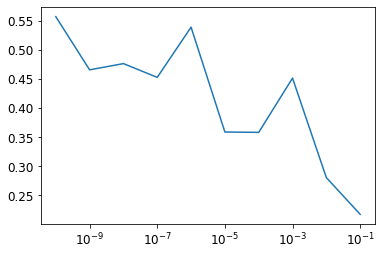

In [56]:
# Measure how long does it take to implement each procedure in seconds
import time
tol = 0.1
tols = []
times = []
for i in range(10):
    # Specifify the model.
    svm_clf = SVC(kernel="poly", gamma=3, C=10, tol=tol, verbose=1)
    # save start time
    t1 = time.time()
    #Estimate the model
    svm_clf.fit(X, y)
    # save finish time
    t2 = time.time()
    # save time vector
    times.append(t2-t1)
    tols.append(tol)
    print(i, tol, t2-t1)
    # Reduce tolerance (epsilon by 10)
    tol /= 10
plt.semilogx(tols, times)
# Change from 0.92 to 0.25 seconds $

## Linear SVM classifier implementation using Batch Gradient Descent

In [57]:
# Training set
X = iris["data"][:, (2, 3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64).reshape(-1, 1) # Iris-Virginica
# It may increase speed

In [58]:
from sklearn.base import BaseEstimator

class MyLinearSVC(BaseEstimator):
    def __init__(self, C=1, eta0=1, eta_d=10000, n_epochs=1000, random_state=None):
        self.C = C
        self.eta0 = eta0
        self.n_epochs = n_epochs
        self.random_state = random_state
        self.eta_d = eta_d
# Learning curve
    def eta(self, epoch):
        return self.eta0 / (epoch + self.eta_d)
        
    def fit(self, X, y):
        # Random initialization
        if self.random_state:
            np.random.seed(self.random_state)
        w = np.random.randn(X.shape[1], 1) # n feature weights
        b = 0

        m = len(X)
        # t function 1 for positive, and -1 for negative
        t = y * 2 - 1  # -1 if t==0, +1 if t==1
        X_t = X * t
        self.Js=[]

        # Training
        for epoch in range(self.n_epochs):
            # Calculate y_hat
            support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
            X_t_sv = X_t[support_vectors_idx]
            t_sv = t[support_vectors_idx]
            #Cost function
            J = 1/2 * np.sum(w * w) + self.C * (np.sum(1 - X_t_sv.dot(w)) - b * np.sum(t_sv))
            self.Js.append(J)
            # Partial J/Partial w
            w_gradient_vector = w - self.C * np.sum(X_t_sv, axis=0).reshape(-1, 1)
            # Partial J/Partial b
            b_derivative = -C * np.sum(t_sv)
            # Update w and b
            w = w - self.eta(epoch) * w_gradient_vector
            b = b - self.eta(epoch) * b_derivative
            

        self.intercept_ = np.array([b])
        self.coef_ = np.array([w])
        # Predictions
        support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
        self.support_vectors_ = X[support_vectors_idx]
        return self

    def decision_function(self, X):
        return X.dot(self.coef_[0]) + self.intercept_[0]

    def predict(self, X):
        return (self.decision_function(X) >= 0).astype(np.float64)

C=2
svm_clf = MyLinearSVC(C=C, eta0 = 10, eta_d = 1000, n_epochs=60000, random_state=2)
svm_clf.fit(X, y)
svm_clf.predict(np.array([[5, 2], [4, 1]]))

array([[1.],
       [0.]])

Plot cost function and epochs

(0.0, 60000.0, 0.0, 100.0)

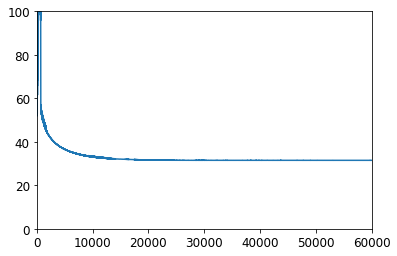

In [59]:
plt.plot(range(svm_clf.n_epochs), svm_clf.Js)
plt.axis([0, svm_clf.n_epochs, 0, 100])

In [60]:
# Gradient descent coefficients
print(svm_clf.intercept_, svm_clf.coef_)

[-15.56761653] [[[2.28120287]
  [2.71621742]]]


In [61]:
# Coefficients from Linear SVM.
svm_clf2 = SVC(kernel="linear", C=C)
svm_clf2.fit(X, y.ravel())
print(svm_clf2.intercept_, svm_clf2.coef_)

[-15.51721253] [[2.27128546 2.71287145]]


(4.0, 6.0, 0.8, 2.8)

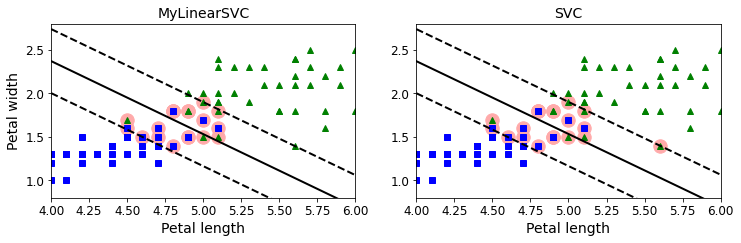

In [62]:
yr = y.ravel()
plt.figure(figsize=(12,3.2))
plt.subplot(121)
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^", label="Iris-Virginica")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs", label="Not Iris-Virginica")
plot_svc_decision_boundary(svm_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("MyLinearSVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])

plt.subplot(122)
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("SVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])


[-12.52988101   1.94162342   1.84544824]


(4.0, 6.0, 0.8, 2.8)

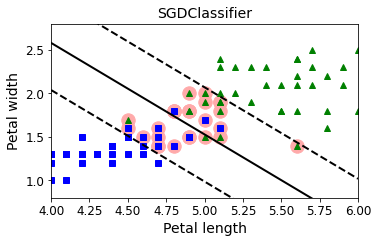

In [63]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="hinge", alpha = 0.017, max_iter = 50, random_state=42)
sgd_clf.fit(X, y.ravel())

m = len(X)
t = y * 2 - 1  # -1 if t==0, +1 if t==1
X_b = np.c_[np.ones((m, 1)), X]  # Add bias input x0=1
X_b_t = X_b * t
sgd_theta = np.r_[sgd_clf.intercept_[0], sgd_clf.coef_[0]]
print(sgd_theta)
support_vectors_idx = (X_b_t.dot(sgd_theta) < 1).ravel()
sgd_clf.support_vectors_ = X[support_vectors_idx]
sgd_clf.C = C

plt.figure(figsize=(5.5,3.2))
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(sgd_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("SGDClassifier", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])
